# Compare with rouse model

In [2]:
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.rouse as rouse

In [3]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-free-angle/3-FENE-beadspring-free-angle/a62b82b9"

## Read and process the data

In [4]:
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_ETE = PATH_EXPERIMENT / "data" / "processed" / "ete.csv"
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data" / "initial_system.data"
PATHS_TRAJECTORIES = [
    PATH_EXPERIMENT / "data/polymer_relax.out",
    PATH_EXPERIMENT / "data/polymer.out",
]

### Read system

In [5]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system

LammpsSystemData(box=-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi, masses=   mass
1   1.0
2   1.0
3   1.0, atoms=       molecule-ID  type         x         y         z  ix  iy  iz
1                1     1  0.000000  0.000000  0.000000   0   0   0
2                1     1  0.764233 -0.425729 -0.419050   0   0   0
3                1     2  0.773821 -0.836732  0.459520   0   0   0
4                1     2  1.285179 -0.524169 -0.303184   0   0   0
5                1     2  0.842282  0.329744 -0.427985   0   0   0
...            ...   ...       ...       ...       ...  ..  ..  ..
15356          120     2  2.223100 -4.629503 -1.213001   0   0   0
15357          120     2  3.138190 -4.879610 -1.415374   0   0   0
15358          120     2  3.490386 -4.054963 -1.045489   0   0   0
15359          120     2  4.079082 -4.712960 -1.447207   0   0   0
15360          120     3  4.141475 -5.573695 -1.004328   0   0   0

[15360 rows x 8 columns], angle

### Read and process trajectories

In [ ]:
PATH_TRAJECTORY_PROCESSED = PATH_EXPERIMENT / "data" / "processed" / "trajectory_unfolded.csv"
PATH_TRAJECTORY_PROCESSED

In [6]:
df_trajectory_unfolded = pd.read_csv(PATH_TRAJECTORY_PROCESSED)
df_trajectory_unfolded

,t,id,type,x,y,z,ix,iy,iz,molecule-ID
0,0,1,1,0.000000,0.000000,0.000000,0,0,0,1
1,0,2,1,0.764233,-0.425729,-0.419050,0,0,0,1
2,0,3,2,0.773821,-0.836732,0.459520,0,0,0,1
3,0,4,2,1.285180,-0.524169,-0.303184,0,0,0,1
4,0,5,2,0.842282,0.329744,-0.427985,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
15355,30000000,15356,2,2.803130,-2.575230,-1.241570,0,0,0,120
15356,30000000,15357,2,2.348950,-1.918350,-1.807590,0,0,0,120
15357,30000000,15358,2,2.297050,-1.065860,-2.262180,0,0,0,120
15358,30000000,15359,2,2.903360,-1.279130,-1.526470,0,0,0,120


### Read and process ETE

In [7]:
df_ete = pd.read_csv(PATH_ETE, index_col=["molecule-ID", "t"])
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x       R_y       R_z          R     t/LJ  \
molecule-ID t                                                             
1           0          9.844740 -2.701840  7.548270  12.696268      0.0   
            100000    10.071300 -3.788600  2.352410  11.014464    250.0   
            200000    16.600600 -9.010100  4.066660  19.320961    500.0   
            300000    15.349100 -5.848040  2.344690  16.591926    750.0   
            400000    16.740700 -3.157660  1.502620  17.102038   1000.0   
...                         ...       ...       ...        ...      ...   
120         29960000   3.221090 -0.088719  1.941870   3.762200  74900.0   
            29970000   1.724150 -4.078280  0.471077   4.452749  74925.0   
            29980000   0.270615 -2.586720 -2.036100   3.303037  74950.0   
            29990000   1.273000 -3.735650  1.003840   4.072260  74975.0   
            30000000   3.228840 -1.049590 -0.592467   3.446457  75000.0   

                             R^2  
molecule-ID t                     
1           0         161.195225  
            100000    121.318406  
            200000    373.299546  
            300000    275.292014  
            400000    292.479720  
...                          ...  
120         29960000   14.154151  
            29970000   19.826975  
            29980000   10.910056  
            29990000   16.583305  
            30000000   11.878064  

[198120 rows x 6 columns]

In [8]:
df_ete_mean = df_ete.groupby("t/LJ")[["R", "R^2"]].mean()
df_ete_mean

,R,R^2
t/LJ,,
0.0,9.671459,111.042003
250.0,10.385773,126.572563
500.0,10.338527,129.858409
750.0,10.312613,128.651250
1000.0,10.478591,132.730088
...,...,...
74900.0,10.472326,128.916430
74925.0,10.528634,130.647809
74950.0,10.382232,127.947296


In [9]:
df_ete_change_mean = pd.DataFrame(transform.calculate_ete_change_ens_avg_df(df_ete), columns=["dR"])
df_ete_change_mean["t/LJ"] = df_ete_change_mean.index.map(lambda x: x * 0.0025)
df_ete_change_mean

,dR,t/LJ
t,,
0,0.000000,0.0
100000,65.355901,250.0
200000,92.473794,500.0
300000,106.988597,750.0
400000,117.891952,1000.0
...,...,...
29960000,235.912010,74900.0
29970000,239.510136,74925.0
29980000,241.232968,74950.0


## Get the constants

### Number of bonds

In [10]:
N_bonds = len(system.bonds) / len(system.atoms["molecule-ID"].unique())
assert N_bonds.is_integer()
N_bonds = int(N_bonds)
N_bonds

127

In [11]:
N_bonds_rouse = N_bonds + 1
N_bonds_rouse

128

### Bond size

Calculate average bond size neglecting the variations: $l_b^2 = \langle \langle (r_k - r_{k-1})^2 \rangle  \rangle_t$ as average over ensemble averaged over time

In [14]:
l_df = df_trajectory_unfolded.groupby("t").apply(transform.calculate_neigh_distance_avg_df, t_equilibrium=0)
l_df

/lustre/scratch2/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


t
0                NaN
100000      0.943346
200000      0.942152
300000      0.941148
400000      0.942228
              ...   
29960000    0.941919
29970000    0.942277
29980000    0.941954
29990000    0.942567
30000000    0.941429
Length: 1651, dtype: float64

In [15]:
l_df.describe()

count    1650.000000
mean        0.942571
std         0.011819
min         0.940538
25%         0.941911
50%         0.942296
75%         0.942653
max         1.421858
dtype: float64

In [16]:
l_b = .97
l_b

0.97

In [19]:
L_contour = l_b * N_bonds
L_contour

123.19

### Rouse time estimated analytically

Svaneborg (15)

Rouse relaxation time:
$$ \tau_R = \frac{1}{3 \pi^2} \frac{\zeta N_b^2 l_b^2}{k_B T}$$
Relaxation time of single bead:
$$ \tau_0 = \frac{\tau_R}{N_b^2} $$

In [26]:
zeta = 1  # LJ
k_B = 1
T = 1
tau_rouse = rouse.rouse_relaxation_time(N_bonds_rouse, l_b, zeta, T, k_B)
tau_rouse

520.6458460246049

## Plot simulation data and rouse predicted

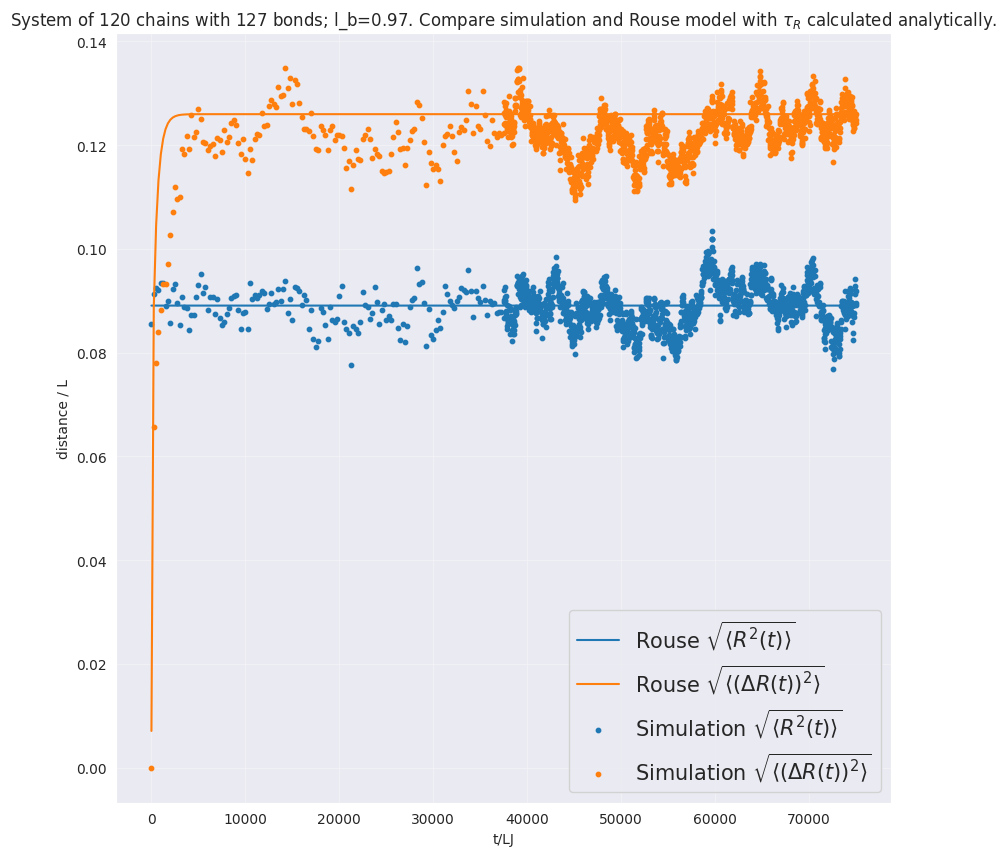

In [25]:
ax: plt.Axes
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(
    df_ete_mean.index,
    np.sqrt(rouse.rouse_R_sq_avg(
        t=df_ete_mean.index,
        N_b=N_bonds_rouse,
        l_b=l_b)
    ) / L_contour,
    label=r"Rouse $ \sqrt{ \langle R^2(t) \rangle } $"
)
ax.plot(
    df_ete_mean.index,
    np.sqrt(rouse.rouse_g_4(
        t=df_ete_mean.index,
        N_b=N_bonds_rouse,
        l_b=l_b,
        tau_R=tau_rouse,
        p_max=int(N_bonds_rouse))
    ) / L_contour,
    label=r"Rouse $ \sqrt{ \langle (\Delta R(t))^2 \rangle } $"
)
ax.scatter(
    df_ete_mean.index,
    np.sqrt(df_ete_mean["R^2"]) / L_contour,
    label=r"Simulation $ \sqrt{ \langle R^2(t) \rangle } $",
    s=10
)
ax.scatter(
    df_ete_change_mean["t/LJ"],
    np.sqrt(df_ete_change_mean["dR"]) / L_contour,
    label=r"Simulation $ \sqrt{ \langle (\Delta R(t))^2 \rangle } $",
    s=10
)
ax.set_xlabel("t/LJ")
ax.set_ylabel("distance / L")
ax.set_title(f"System of 120 chains with {N_bonds} bonds; l_b={l_b:.2f}. Compare simulation and Rouse model with $\\tau_R$ calculated analytically.")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=15)

## Estimate rouse time from the fit and compare

In [29]:
from functools import partial

popt, pcov = scipy.optimize.curve_fit(
    partial(rouse.rouse_g_4, p_max=N_bonds_rouse, N_b=N_bonds_rouse, l_b=l_b),
    xdata=df_ete_change_mean["t/LJ"],
    ydata=df_ete_change_mean["dR"],
    p0=tau_rouse,
)
popt, pcov

(array([2136.50732588]), array([[24087.14332941]]))

In [30]:
t_rouse_fit = popt[0]
dt_rouse_fit = np.sqrt(np.diag(pcov))[0]
print(f"Estimated rouse time (+- 1std err) = {t_rouse_fit} +- {dt_rouse_fit}")

Estimated rouse time (+- 1std err) = 2136.507325884539 +- 155.20033289078827


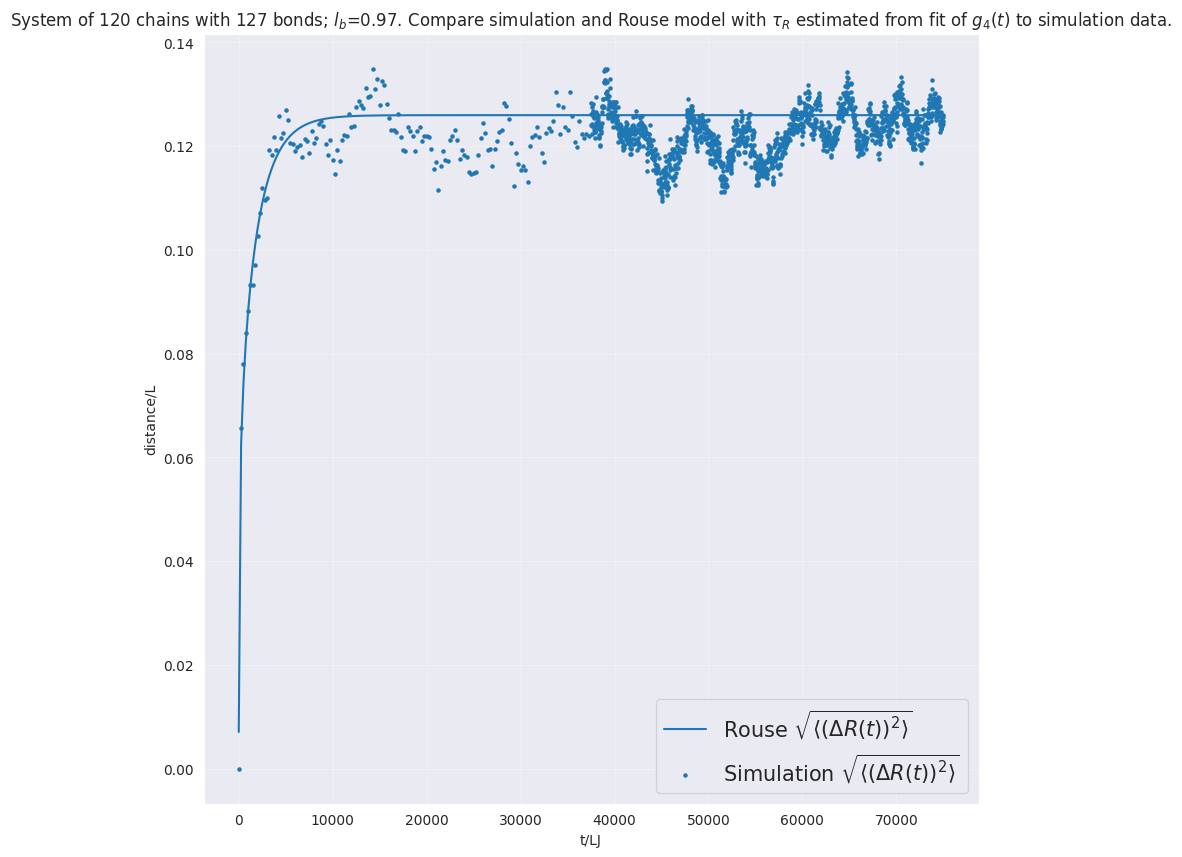

In [33]:
ax: plt.Axes
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(
    df_ete_mean.index,
    np.sqrt(rouse.rouse_g_4(df_ete_mean.index, N_b=N_bonds_rouse, l_b=l_b, tau_R=t_rouse_fit, p_max=int(N_bonds_rouse))) / L_contour,
    label=r"Rouse $ \sqrt{ \langle (\Delta R(t))^2 \rangle } $"
)
ax.scatter(
    df_ete_change_mean["t/LJ"],
    np.sqrt(df_ete_change_mean["dR"]) / L_contour,
    label=r"Simulation $ \sqrt{ \langle (\Delta R(t))^2 \rangle } $",
    s=5
)
ax.set_xlabel("t/LJ")
ax.set_ylabel("distance/L")
ax.set_title(f"System of 120 chains with {N_bonds} bonds; $l_b$={l_b:.2f}. Compare simulation and Rouse model with $\\tau_R$ estimated from fit of $g_4(t)$ to simulation data.")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=15)

In [39]:
tau_0_theory = rouse.relaxation_time_bead(tau_rouse, N_bonds_rouse)
tau_0_empirical = rouse.relaxation_time_bead(t_rouse_fit, N_bonds_rouse)
d_tau_0_empirical = rouse.relaxation_time_bead(dt_rouse_fit, N_bonds_rouse)

print(f"Empirical: tau_0~={tau_0_empirical:.3f}+-{d_tau_0_empirical:.3f}")
print(f"Theory: tau_0~={tau_0_theory:.3f}")

Empirical: tau_0~=0.130+-0.009
Theory: tau_0~=0.032


In [ ]:
adjustment_factor_alpha = tau_0_empirical / tau_0_theory
print(f"Estimated Adjustment factor: {adjustment_factor_alpha}")